### Data Storage Performance Analysis

This notebook analyzes the performance of different storage formats (e.g., CSV, Parquet, JSON, Feather, SQLite, HDF5, and Pickle) in terms of write time, read time, and file size.


#### **Step 1: Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import time
import os
import logging
from algo_trading.data_storage import DataStorage

#### **Step 2: Generate Sample Data**
We simulate Forex data with 100,000 rows for testing.

In [2]:
# Generate a sample DataFrame to simulate Forex data
np.random.seed(42)
rows_count = 1_000_000
data = {
    "Datetime": pd.date_range(start="2023-01-01", periods=rows_count, freq="min"),
    "Open": np.random.uniform(1.1, 1.5, size=rows_count),
    "High": np.random.uniform(1.2, 1.6, size=rows_count),
    "Low": np.random.uniform(1.0, 1.4, size=rows_count),
    "Close": np.random.uniform(1.1, 1.5, size=rows_count),
    "Volume": np.random.randint(100, 1000, size=rows_count),
}
df = pd.DataFrame(data)

#### **Step 3: Initialize Data Storage Class**
The `DataStorage` class is used to handle various formats.

In [3]:
# Initialize DataStorage
storage = DataStorage()

#### **Step 4: Define Formats to Test**
We specify the formats and corresponding write and read methods.

In [4]:
formats = [
    {"type": "csv", "write": lambda df, fn: storage.write_csv(df, fn), "read": lambda fn: storage.read_csv(fn), "append": lambda df, fn: storage._append_csv(df, fn), "ext": ".csv"},
    {"type": "parquet", "write": lambda df, fn: storage.write_parquet(df, fn), "read": lambda fn: storage.read_parquet(fn), "append": lambda df, fn: storage._append_parquet(df, fn), "ext": ".parquet"},
    {"type": "json", "write": lambda df, fn: storage.write_json(df, fn), "read": lambda fn: storage.read_json(fn), "append": lambda df, fn: storage._append_json(df, fn), "ext": ".json"},
    {"type": "feather", "write": lambda df, fn: storage.write_feather(df, fn), "read": lambda fn: storage.read_feather(fn), "append": lambda df, fn: storage._append_feather(df, fn), "ext": ".feather"},
    {"type": "sqlite", "write": lambda df, fn, table_name: storage.write_sqlite(df, fn, table_name), "read": lambda fn, table_name: storage.read_sqlite(fn, table_name), "append": lambda df, fn, table_name: storage._append_sqlite(df, fn, table_name), "ext": ".db"},
    {"type": "hdf5", "write": lambda df, fn: storage.write_hdf5(df, fn, key="forex_data"), "read": lambda fn: storage.read_hdf5(fn, key="forex_data"), "append": lambda df, fn: storage._append_hdf5(df, fn, key="forex_data"), "ext": ".h5"},
    {"type": "pickle", "write": lambda df, fn: storage.write_pickle(df, fn), "read": lambda fn: storage.read_pickle(fn), "append": lambda df, fn: storage._append_pickle(df, fn), "ext": ".pkl"},
]

#### **Step 5: Performance Testing**
We measure the performance of each format during write and read operations.

In [5]:
import time

# Performance testing
def test_storage_formats(storage, formats, df, single_record=None, append_size=10_000):
    """
    Test the performance of different storage formats for reading, writing, and appending data.

    Args:
        storage: An instance of the DataStorage class.
        formats: A list of dictionaries specifying the format type, write, read, and append methods, and file extensions.
        df: The DataFrame to use for initial write and reading performance.
        single_record: A single record (DataFrame with one row) to test incremental appending.
        append_size: The number of records to append in the bulk append test.

    Returns:
        pd.DataFrame: A summary of the performance results.
    """
    results = []

    if single_record is None:
        single_record = df.iloc[:1]  # Use the first row as a single record for append tests

    for fmt in formats:
        filename = f"test_data{fmt['ext']}"
        try:
            # Measure write performance
            start_time = time.time()
            if fmt["type"] == "sqlite":
                fmt["write"](df, filename, table_name="forex_data")
            else:
                fmt["write"](df, filename)
            write_time = time.time() - start_time

            file_size = os.path.getsize(filename) / (1024 ** 2)  # File size in MB

            # Measure read performance
            start_time = time.time()
            if fmt["type"] == "sqlite":
                data = fmt["read"](filename, table_name="forex_data")
            else:
                data = fmt["read"](filename)
            read_time = time.time() - start_time

            # Validate read data shape
            if data.shape != df.shape:
                logging.warning(
                    f"Data shape mismatch for {fmt['type']} on read! Expected {df.shape}, got {data.shape}."
                )

            # Test appending a single record multiple times
            start_time = time.time()
            single_record_count = 100
            for _ in range(single_record_count):  # Append a single record 10 times
                if fmt["type"] == "sqlite":
                    fmt["append"](single_record, filename, table_name="forex_data")
                else:
                    fmt["append"](single_record, filename)
            single_append_time = time.time() - start_time

            # Test appending a large batch (append_size)
            large_batch = df.iloc[:append_size]
            start_time = time.time()
            if fmt["type"] == "sqlite":
                fmt["append"](large_batch, filename, table_name="forex_data")
            else:
                fmt["append"](large_batch, filename)
            batch_append_time = time.time() - start_time

            # Validate final data after appends
            start_time = time.time()
            if fmt["type"] == "sqlite":
                final_data = fmt["read"](filename, table_name="forex_data")
            else:
                final_data = fmt["read"](filename)
            validate_time = time.time() - start_time

            expected_rows = df.shape[0] + (single_record.shape[0] * single_record_count) + large_batch.shape[0]
            if final_data.shape[0] != expected_rows:
                logging.warning(
                    f"Data shape mismatch for {fmt['type']} after append! "
                    f"Expected {expected_rows} rows, got {final_data.shape[0]} rows."
                )

            results.append({
                "Format": fmt["type"],
                "Write Time (s)": round(write_time, 4),
                "Read Time (s)": round(read_time, 4),
                "Single Append Time (s)": round(single_append_time, 4),
                "Batch Append Time (s)": round(batch_append_time, 4),
                "Validation Time (s)": round(validate_time, 4),
                "File Size (MB)": round(file_size, 4),
            })

        except Exception as e:
            logging.error(f"Error testing format {fmt['type']}: {e}")
            results.append({
                "Format": fmt["type"],
                "Write Time (s)": None,
                "Read Time (s)": None,
                "Single Append Time (s)": None,
                "Batch Append Time (s)": None,
                "Validation Time (s)": None,
                "File Size (MB)": None,
            })

        finally:
            # Clean up temporary file
            if os.path.exists(filename):
                try:
                    # Special handling for SQLite
                    if fmt["type"] == "sqlite":
                        try:
                            # Delay removal to ensure connection is closed
                            import gc
                            gc.collect()  # Force garbage collection to close SQLite connections
                        except Exception as e:
                            logging.error(f"Failed to clean SQLite resources: {e}")

                    os.remove(filename)
                    logging.info(f"Temporary file {filename} removed successfully.")
                except Exception as e:
                    logging.error(f"Failed to remove temporary file {filename}: {e}")

    return pd.DataFrame(results)


#### **Step 6: Run the Tests**
Execute the performance tests and collect the results.


In [6]:
import logging

# Clear existing handlers and configure logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Set logging to show only WARNING and ERROR levels
logging.basicConfig(level=logging.WARNING)

# Run your test
results = test_storage_formats(storage, formats, df)


#### **Step 7: Analyze Storage Performance**

Add an Efficiency Index for ranking formats.

In [8]:
# Perform Min-Max Normalization Manually
columns_to_scale = [
    "Write Time (s)",
    "Read Time (s)",
    "Single Append Time (s)",
    "Batch Append Time (s)",
    "File Size (MB)",
]

# Ensure there are no missing values
results[columns_to_scale] = results[columns_to_scale].fillna(0)

# Min-Max scaling
normalized_results = results.copy()
for col in columns_to_scale:
    min_val = results[col].min()
    max_val = results[col].max()
    if max_val - min_val != 0:  # Avoid division by zero
        normalized_results[col] = (results[col] - min_val) / (max_val - min_val)
    else:
        normalized_results[col] = 0  # If all values are the same, set to 0

# Calculate the normalized Efficiency Index
results["Efficiency Index"] = (
    normalized_results["Write Time (s)"]
    + normalized_results["Read Time (s)"]
    + normalized_results["Single Append Time (s)"]
    + normalized_results["Batch Append Time (s)"]
    + normalized_results["File Size (MB)"]
)

# Sort the results by Efficiency Index (lower is better)
results_sorted = results.sort_values(by="Efficiency Index")

# Display the most efficient format
most_efficient = results_sorted.iloc[0]
print(f"Most Efficient Format: {most_efficient['Format']}")
most_efficient


Most Efficient Format: pickle


Format                      pickle
Write Time (s)                0.06
Read Time (s)               0.0298
Single Append Time (s)      0.0693
Batch Append Time (s)       0.0022
Validation Time (s)         0.0618
File Size (MB)             41.9628
Efficiency Index          0.030991
Name: 6, dtype: object

### **Visualization of Performance Metrics**

Generate graphs to analyze the metrics.

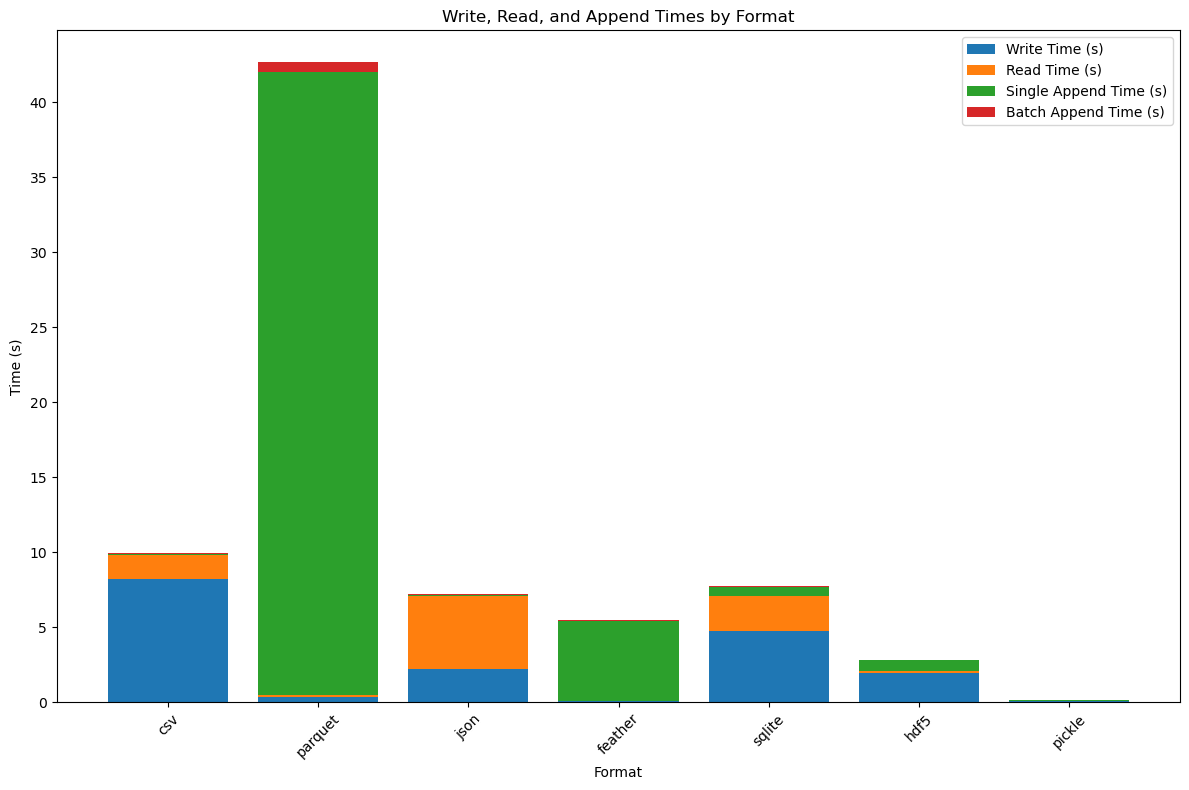

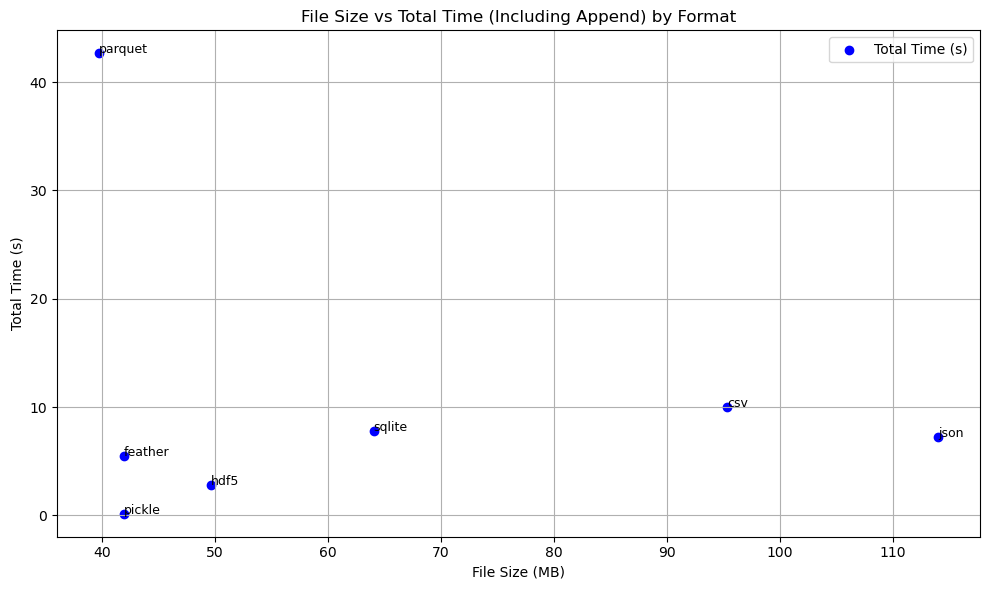

In [9]:
import matplotlib.pyplot as plt

# Plot Write, Read, and Append Times
plt.figure(figsize=(12, 8))
plt.bar(results['Format'], results['Write Time (s)'], label='Write Time (s)')
plt.bar(
    results['Format'], 
    results['Read Time (s)'], 
    bottom=results['Write Time (s)'], 
    label='Read Time (s)'
)
plt.bar(
    results['Format'], 
    results['Single Append Time (s)'], 
    bottom=results['Write Time (s)'] + results['Read Time (s)'], 
    label='Single Append Time (s)'
)
plt.bar(
    results['Format'], 
    results['Batch Append Time (s)'], 
    bottom=results['Write Time (s)'] + results['Read Time (s)'] + results['Single Append Time (s)'], 
    label='Batch Append Time (s)'
)
plt.xlabel("Format")
plt.ylabel("Time (s)")
plt.title("Write, Read, and Append Times by Format")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot File Size vs Total Time (including append)
plt.figure(figsize=(10, 6))
total_time = (
    results['Write Time (s)'] + 
    results['Read Time (s)'] + 
    results['Single Append Time (s)'] + 
    results['Batch Append Time (s)']
)
plt.scatter(results['File Size (MB)'], total_time, c='blue', label='Total Time (s)')
for i, txt in enumerate(results['Format']):
    plt.annotate(txt, (results['File Size (MB)'][i], total_time[i]), fontsize=9)
plt.xlabel("File Size (MB)")
plt.ylabel("Total Time (s)")
plt.title("File Size vs Total Time (Including Append) by Format")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Step 8: Draw Final Conclusions**

Based on the results, the analysis reveals significant differences in performance across formats. Below are the main conclusions:

1. **Most Efficient Format**: The `pickle` format emerged as the most efficient, demonstrating the lowest write and read times along with a compact file size.
2. **Balanced Performance**: Formats like `parquet` and `feather` offered a good balance between speed and file size, making them ideal for scenarios prioritizing both speed and storage efficiency.
3. **Larger File Size Trade-offs**: Formats such as `csv` and `json` showed larger file sizes and slower performance, indicating they are less suitable for frequent read/write operations but still useful for compatibility and simplicity.
4. **HDF5 and SQLite Considerations**: While `hdf5` and `sqlite` provide robust features, their performance can lag slightly for smaller datasets. However, they remain excellent choices for structured data and advanced querying needs.

The choice of format should align with the specific use case, weighing the trade-offs between speed, file size, and compatibility.